# Machine Learning Project
## Mbusu-Team

### **House Prices Dataset**

### **Data Understanding**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sb
from scipy.stats import entropy
import math
import sys
from itertools import groupby
plt.style.use('ggplot')


hue_order = ["HIGH","MEDIUM","LOW"]
color = ["#BF4E30","#2E86AB","#E7A012"]
palette = {
    'LOW': color[0],
    'MEDIUM': color[1],
    'HIGH': color[2],
}
TARGET_FEATURE = 'SalePrice'
TARGET_FEATURE_CONTI = 'salePriceNum'
TARGET_FEATURE_VALUES = ['LOW', 'MEDIUM', 'HIGH']

#### Utils

###### INFORMATION GAIN FUNTION 

In [3]:
def IG(df, target, attribute):

    df_sub = []

    for value in df[attribute].unique():
        df_sub.append( df[df[attribute] == value] )
        
    counts = df[target].value_counts()
    probs = counts / len(df)
    e = -np.sum(probs * np.log2(probs))

    information_gain = e 
    for df_s in df_sub:
        counts = df_s[target].value_counts()
        probs = counts / len(df_s)
        e_s = -np.sum(probs * np.log2(probs))
        information_gain -= len(df_s) / len(df) * e_s

    return information_gain


###### Mean

In [4]:
def mean_attribute(df, attribute):
    mean_low = df[ ( df["SalePrice"] == 'LOW' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_medium = df[ ( df["SalePrice"] == 'MEDIUM' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_high = df[ ( df["SalePrice"] == 'HIGH' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    return (mean_low, mean_medium, mean_high)



###### Set means

In [5]:
def set_means(df,attribute):
    mean_values = mean_attribute(df,attribute)

    for ind , e  in df.iterrows():
        if e[attribute] == "NA":
            if(e["SalePrice"] == "LOW"):
                df.at[ind, attribute] = mean_values[0]
            elif e["SalePrice"] == "MEDIUM":
                df.at[ind, attribute] = mean_values[1]
            else:
                df.at[ind, attribute] = mean_values[2]


    df[attribute] = df[attribute].astype("int")


###### Plot frequencies and percentages

In [6]:
def frequencies_and_percentages(df, target, attribute):
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    dfp = df[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df[target].unique()), axis='index'))
    display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color )
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )

###### Histplot

In [7]:

def histplot(df,target, attribute, bins = None , figsize=(15,5) ):
    if bins is None:
        bins = len(df)
    plt.figure(figsize = figsize)
    sb.histplot(x = df[attribute], hue = target, data = df, kde=True , hue_order = hue_order, palette = palette, bins = bins , common_bins= False)
    plt.show()

###### indepence_test_categoric

In [8]:

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            if pos % 3 == 0: add_line(ax, pos*scale, ypos - .052)
            pos += rpos
        add_line(ax, pos*scale , ypos - .052)
        ypos -= .05

def barplot_diffvalues(dataset, feature_name):
    df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(dataset)
    dataset.pivot_table(index = [feature_name, TARGET_FEATURE], columns=['__Type']).plot(kind='bar', ax=ax, width=.7)
    
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title('Expected/Observed Frequencies')
    ax.set_xlabel(f'{feature_name}/{TARGET_FEATURE}', labelpad=40)
    ax.set_ylabel(f'{TARGET_FEATURE}')
    plt.legend(['Expected', 'Observed'])
    label_group_bar_table(ax, df)

    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    plt.show()

def stattest_quali(df, feature_name: str, fig_width=15, fig_height=3, typeplot = 'heatmap' ):

    #
    # chi-square test and expected frequencies matrix
    #
    crosstab = pd.crosstab(df[feature_name], df[TARGET_FEATURE])
    chi_square_args = crosstab.values
    _, p_value, _, _ = stats.chi2_contingency(chi_square_args)

    expf_crosstab = pd.DataFrame(crosstab)
    for idx in expf_crosstab.index:
        for col in expf_crosstab.columns:
            expf_crosstab.at[idx, col] = crosstab.loc[idx].values.sum() * crosstab[col].values.sum() / crosstab.values.sum()


    #
    # observed/expected frequencies heatmaps
    #
    fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_height * 2))
    sb.heatmap(crosstab.T, ax=ax[0], annot=True, cmap='coolwarm', fmt='.2f')
    sb.heatmap(expf_crosstab.T, ax=ax[1], annot=True, cmap='coolwarm', fmt='.2f')
    ax[0].set_title('Observed Frequencies')    
    ax[1].set_title('Expected Frequencies')
    fig.tight_layout()
    plt.show()

    if(typeplot == 'heatmap'):
        
        #
        # frequencies difference heatmap
        #
        obsexp_diff_df = crosstab - expf_crosstab
        fig = plt.figure(figsize=(fig_width, fig_height))
        plt.title("Frequency Differences (Observed - Expected)")
        sb.heatmap(obsexp_diff_df.T, annot=True, cmap='vlag', fmt='.2f')
    
    elif typeplot == 'barplot':
        #
        # observed/expected frequencies barplot
        #
        value_vars_x = [val + '_x' for val in TARGET_FEATURE_VALUES]
        value_vars_y = [val + '_y' for val in TARGET_FEATURE_VALUES]
        value_vars_xy = value_vars_x + value_vars_y
        obs_exp_df = pd.merge(crosstab, expf_crosstab, on=[feature_name]).reset_index()
        obs_exp_df = pd.melt(obs_exp_df, id_vars=[feature_name], value_vars=value_vars_xy)
        obs_exp_df['__Type'] = obs_exp_df[TARGET_FEATURE]

        for val in value_vars_x: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__OBS'
        for val in value_vars_y: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__EXP'

        for price in TARGET_FEATURE_VALUES:
            for obs_exp in ['x', 'y']:
                obs_exp_df.loc[obs_exp_df[TARGET_FEATURE] == price + '_' + obs_exp, TARGET_FEATURE] = price[0]

        barplot_diffvalues(obs_exp_df, feature_name)

    #
    # chi-square test outcome
    #
    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    print("Chi-square Test - Outcome")
    print("P-Value:", p_value, p_value_info)

###### indepence_test_numeric

In [9]:
def stattest_quanti(df, feature_name: str, target = TARGET_FEATURE ,low_limit=0, upper_limit=100):

    #
    # plot means w.r.t. target categories
    #
    df_conti_origin = df[[feature_name, target, TARGET_FEATURE_CONTI]] if ( target == TARGET_FEATURE) else None
    df_categ_origin = df[[feature_name, target]]
    df = df_categ_origin.groupby(target)
    mean_df = df.mean().reset_index().rename(columns={feature_name: feature_name + ' (AVG)'})

    num = 3
    if df_conti_origin is None:
        num = 2
    _, ax = plt.subplots(1, num, figsize=(20, 5))

    mean_df.plot(kind='bar', x=target, ax=ax[0])
    for container in ax[0].containers:
        ax[0].bar_label(container, fmt='%.1f')
    ax[0].set_ylim(low_limit, upper_limit)
    ax[0].tick_params(labelrotation=0)

    sb.histplot(x=feature_name, hue=target, data=df_categ_origin, kde=True, ax=ax[1])
    for tval in TARGET_FEATURE_VALUES:
        ax[1].axvline(x=df_categ_origin[df_categ_origin[target] == tval][feature_name].mean(), color='gray', ls='--', lw=1.5)
    
    if df_conti_origin is not None : sb.regplot(x=feature_name, y=TARGET_FEATURE_CONTI, data=df_conti_origin, line_kws={"color": "darkred"}, ax=ax[2])
    
    #
    # perform ANOVA test
    #
    anova_args = tuple(df[feature_name].apply(list).reset_index()[feature_name])
    f_statistic, p_value = stats.f_oneway(*anova_args)

    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    print("ANOVA Test - Outcome")
    print("P-Value:", p_value, p_value_info)

###### Numeric Numeric Correlation

In [10]:
def correlation(df, n1, n2):

    sb.regplot(x=n1, y=n2, data=df, line_kws={"color": "darkred"})
    
    corr, p_values = stats.pearsonr(df[n1], df[n2])
    
    print(corr, p_values)

#### Read data

In [11]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', keep_default_na = False, low_memory= False )
df["salePriceNum"] = df.SalePrice.rename("salePriceNum")
df["SalePrice"] = pd.cut(df["salePriceNum"], bins = [0,150000,300000 - 1 ,int(sys.maxsize)], labels=["LOW","MEDIUM","HIGH"])

In [12]:
df.shape

(1460, 82)

In [13]:
df.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,salePriceNum
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### View Data

In [14]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,salePriceNum
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,2,2008,WD,Normal,MEDIUM,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,5,2007,WD,Normal,MEDIUM,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,9,2008,WD,Normal,MEDIUM,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,2,2006,WD,Abnorml,LOW,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,12,2008,WD,Normal,MEDIUM,250000


#### Info data

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   object  
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

#### Classes

In [16]:
df.SalePrice.unique()

['MEDIUM', 'LOW', 'HIGH']
Categories (3, object): ['LOW' < 'MEDIUM' < 'HIGH']

#### Undestanding the effect of the attributes

##### ID

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.00000000e+00, 1.99931507e+00, 2.99863014e+00, ...,
        1.45800137e+03, 1.45900068e+03, 1.46000000e+03]),
 <BarContainer object of 1460 artists>)

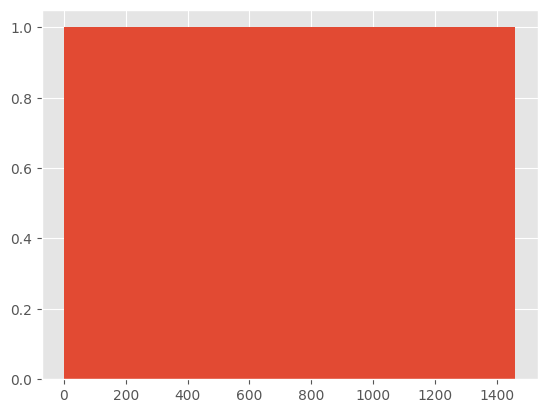

In [17]:
plt.hist(df["Id"], bins= len(df))

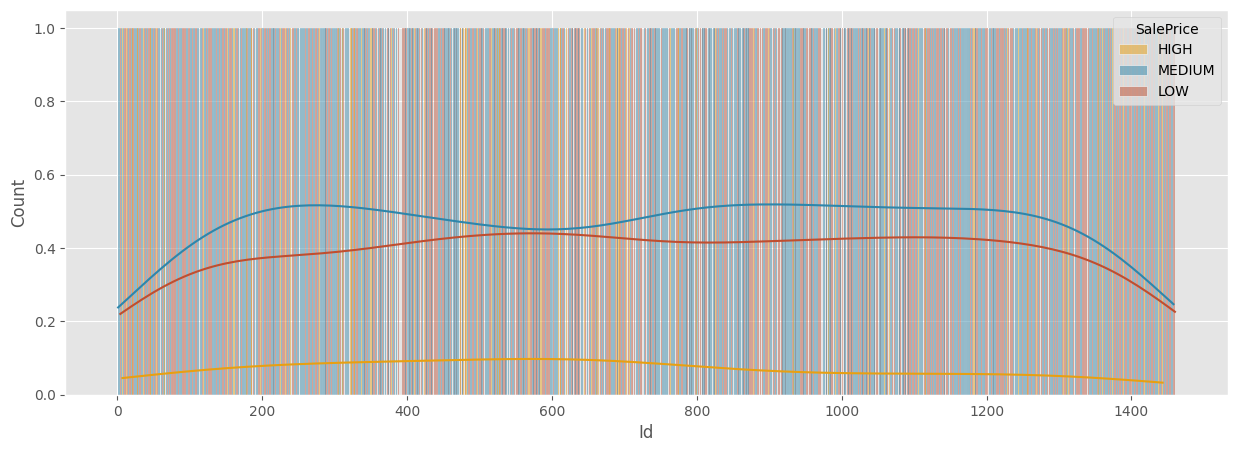

In [18]:
histplot(df,'SalePrice',"Id")

In [19]:
print("Max Entropy ( Log n ) -> " + str(math.log(len(df), 2)))

counts = df['Id'].value_counts()
probs = counts / len(df)
e = -np.sum(probs * np.log2(probs))
print("Entropy -> "+ str(e))

Max Entropy ( Log n ) -> 10.51175265376738
Entropy -> 10.511752653767381


##### MSSubClass

In [20]:
df["MSSubClass"] = df["MSSubClass"].astype("category")

SalePrice,LOW,MEDIUM,HIGH
MSSubClass,,,
20,43.097015,47.761194,9.141791
30,97.101449,2.898551,0.000000
40,50.000000,50.000000,0.000000
45,100.000000,0.000000,0.000000
50,72.222222,25.000000,2.777778
60,2.006689,80.936455,17.056856
70,45.000000,51.666667,3.333333
75,43.750000,43.750000,12.500000
80,29.310345,68.965517,1.724138


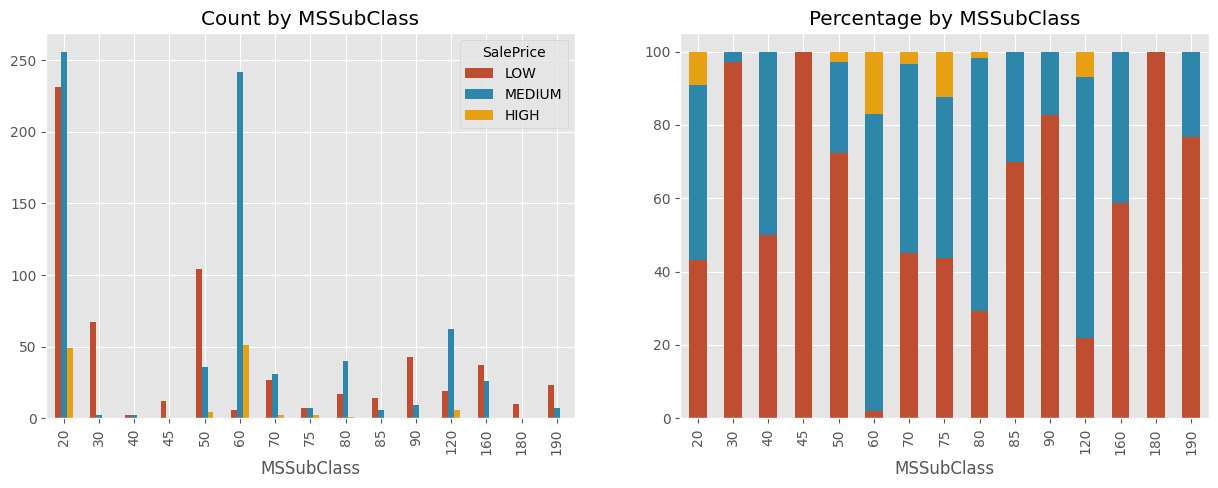

In [21]:
frequencies_and_percentages(df, 'SalePrice', 'MSSubClass')

In [22]:
IG(df,"SalePrice","MSSubClass")

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.28611883641757957

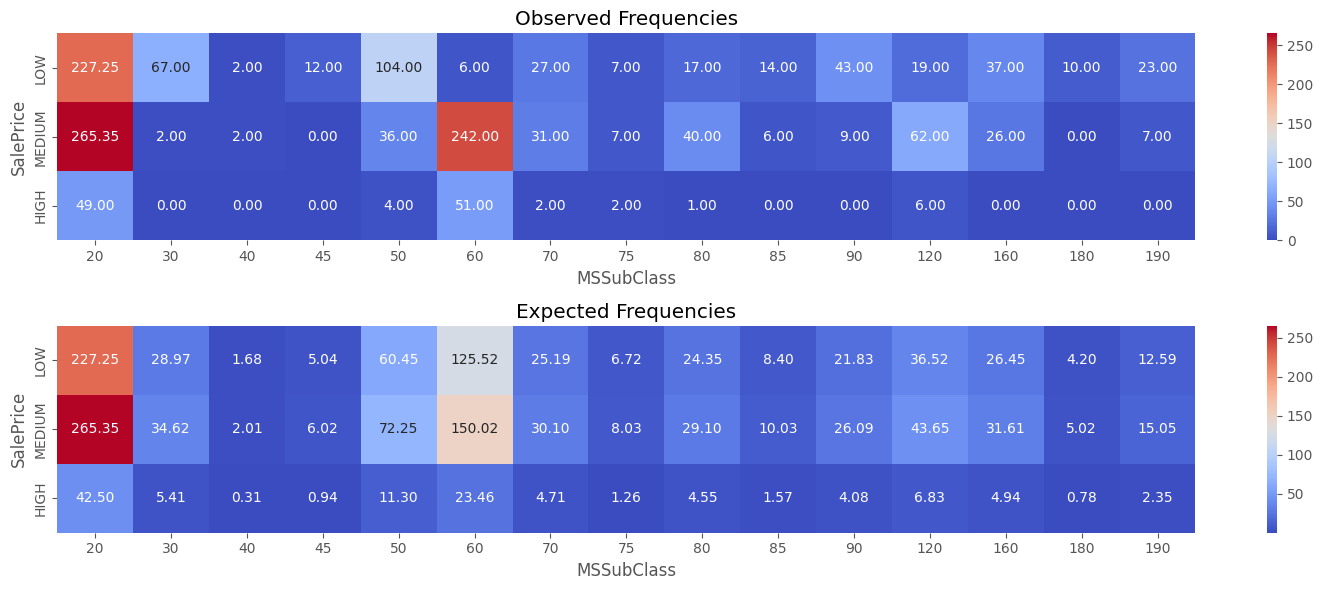

Chi-square Test - Outcome
P-Value: 1.122234664911419e-81 [<0.05]


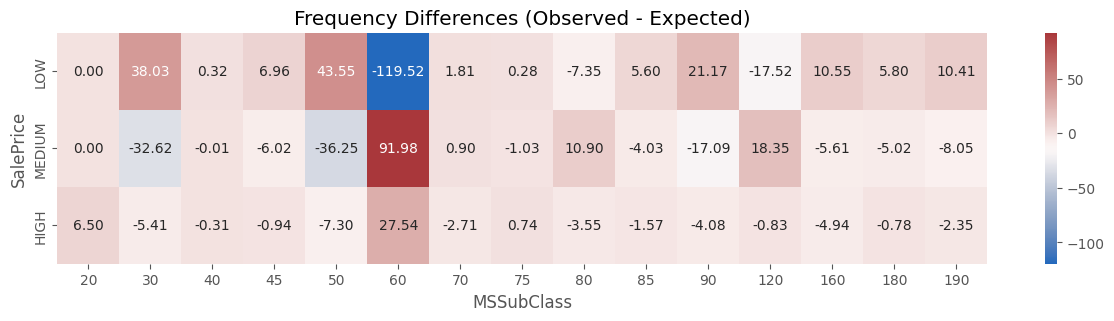

In [23]:
# Indepence test

stattest_quali(df, 'MSSubClass')

##### HouseStyle

SalePrice,LOW,MEDIUM,HIGH
HouseStyle,,,
1.5Fin,71.428571,25.974026,2.597403
1.5Unf,100.000000,0.000000,0.000000
1Story,47.382920,45.041322,7.575758
2.5Fin,25.000000,62.500000,12.500000
2.5Unf,63.636364,27.272727,9.090909
2Story,20.224719,67.865169,11.910112
SFoyer,78.378378,21.621622,0.000000
SLvl,35.384615,63.076923,1.538462


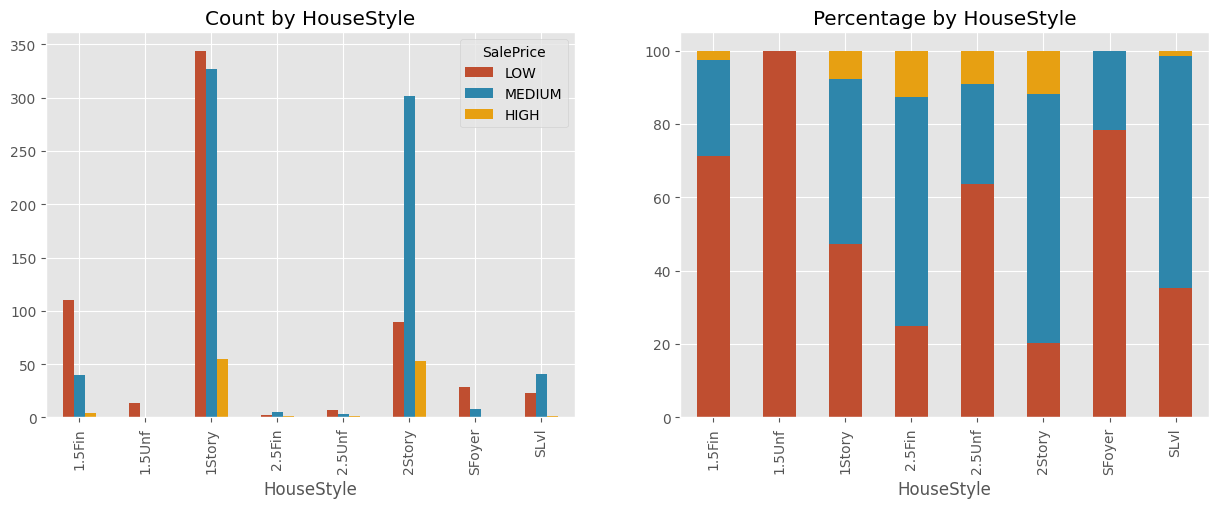

In [24]:
frequencies_and_percentages(df, 'SalePrice', 'HouseStyle')

##### MSZoning

In [25]:
df["MSZoning"] = df["MSZoning"].astype("category")

In [26]:
IG(df, "MSZoning", "SalePrice")


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.12336354296168264

<AxesSubplot: >

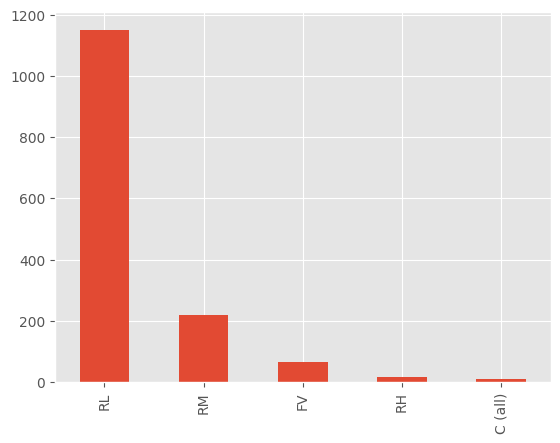

In [27]:
df["MSZoning"].value_counts().plot(kind="bar")

SalePrice,LOW,MEDIUM,HIGH
MSZoning,,,
C (all),100.000000,0.000000,0.000000
FV,6.153846,84.615385,9.230769
RH,75.000000,25.000000,0.000000
RL,35.708080,55.082537,9.209383
RM,83.486239,15.137615,1.376147


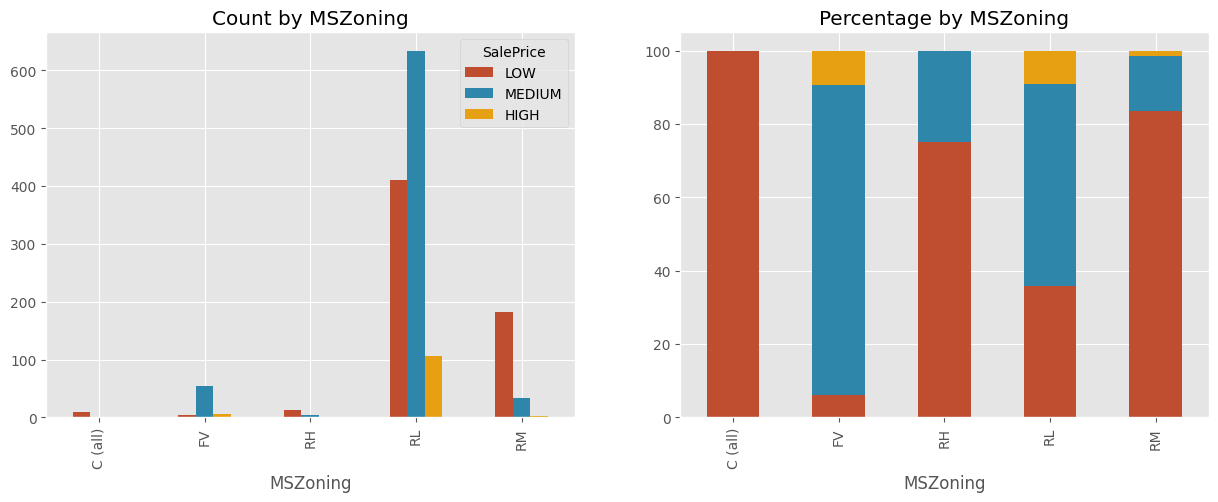

In [28]:
frequencies_and_percentages(df, 'SalePrice', 'MSZoning')

##### YearBuilt

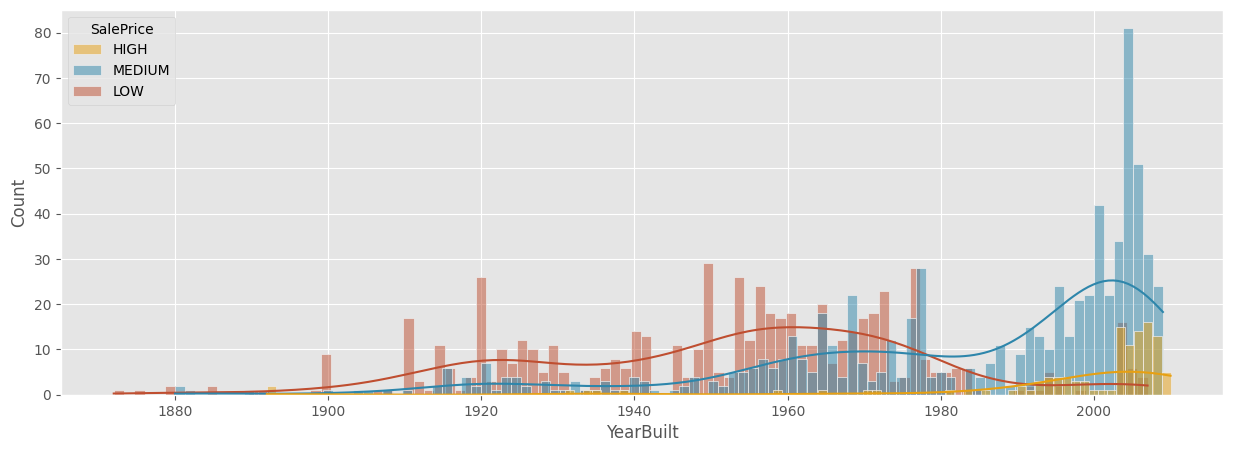

In [29]:
histplot(df,'SalePrice',"YearBuilt",bins=100)
    

ANOVA Test - Outcome
P-Value: 3.6397089066086615e-118 [<0.05]


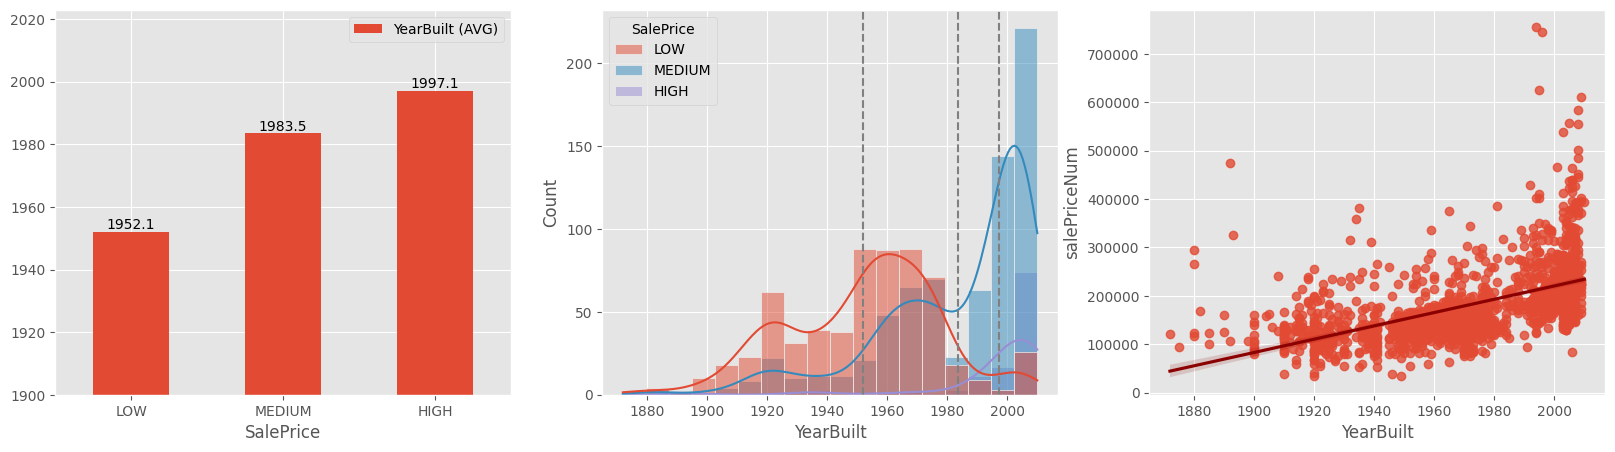

In [30]:
stattest_quanti(df,'YearBuilt', low_limit=1900, upper_limit=2023)

##### LotFrontage

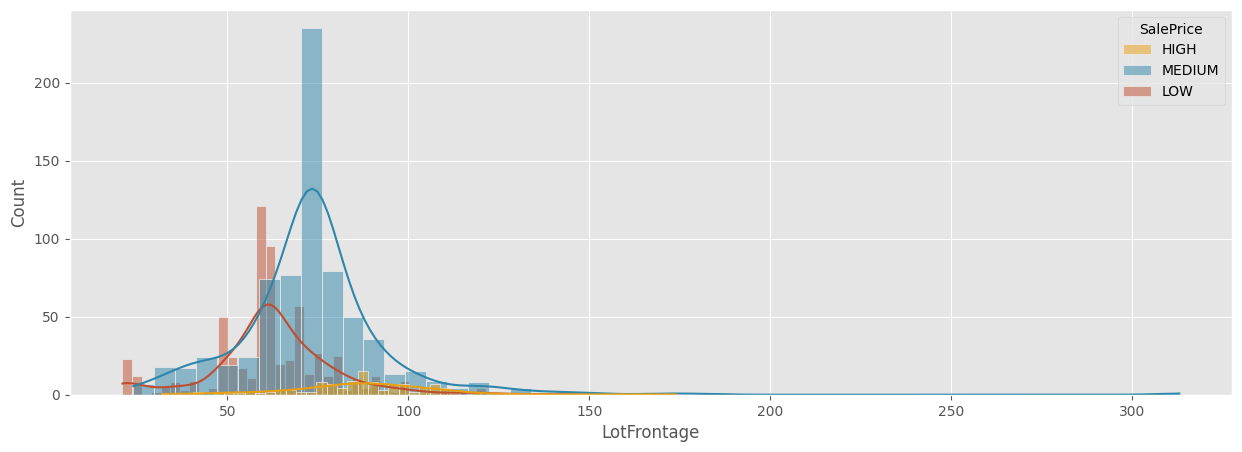

In [31]:
set_means(df,'LotFrontage')


histplot(df,'SalePrice',"LotFrontage", bins=50)


##### CentralAir

In [32]:
IG(df,'SalePrice','CentralAir')

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.05543545701641376

SalePrice,LOW,MEDIUM,HIGH
CentralAir,,,
N,91.578947,8.421053,0.000000
Y,38.974359,52.600733,8.424908


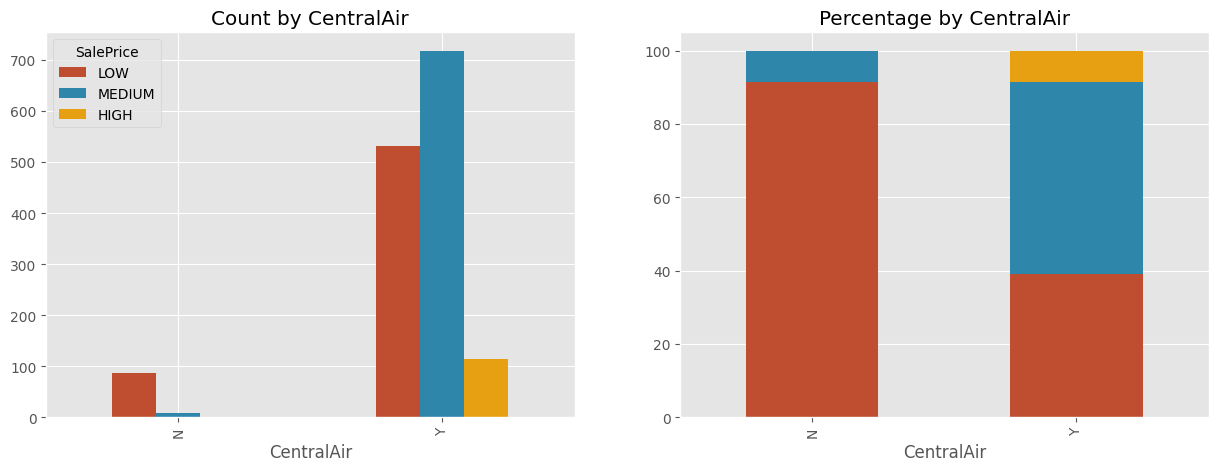

In [33]:
frequencies_and_percentages(df,'SalePrice','CentralAir')

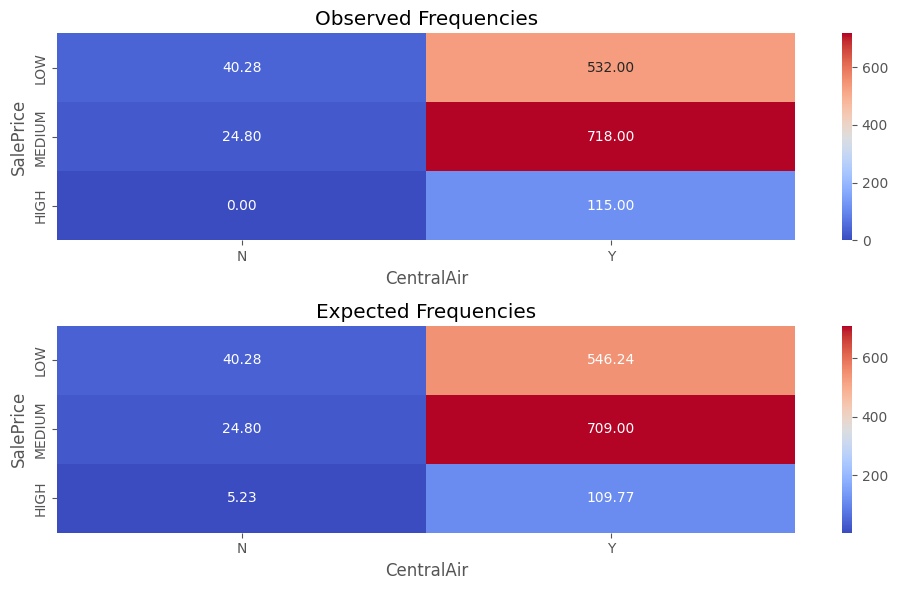

Chi-square Test - Outcome
P-Value: 1.2685848517032062e-22 [<0.05]


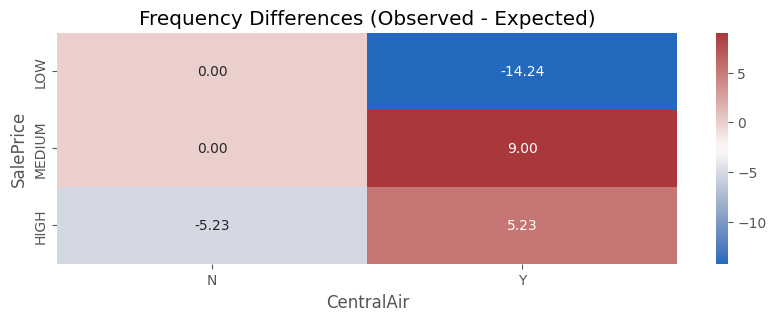

In [44]:
stattest_quali(df,'CentralAir', typeplot='heatmap', fig_width=10)

ANOVA Test - Outcome
P-Value: 7.00278021431306e-52 [<0.05]


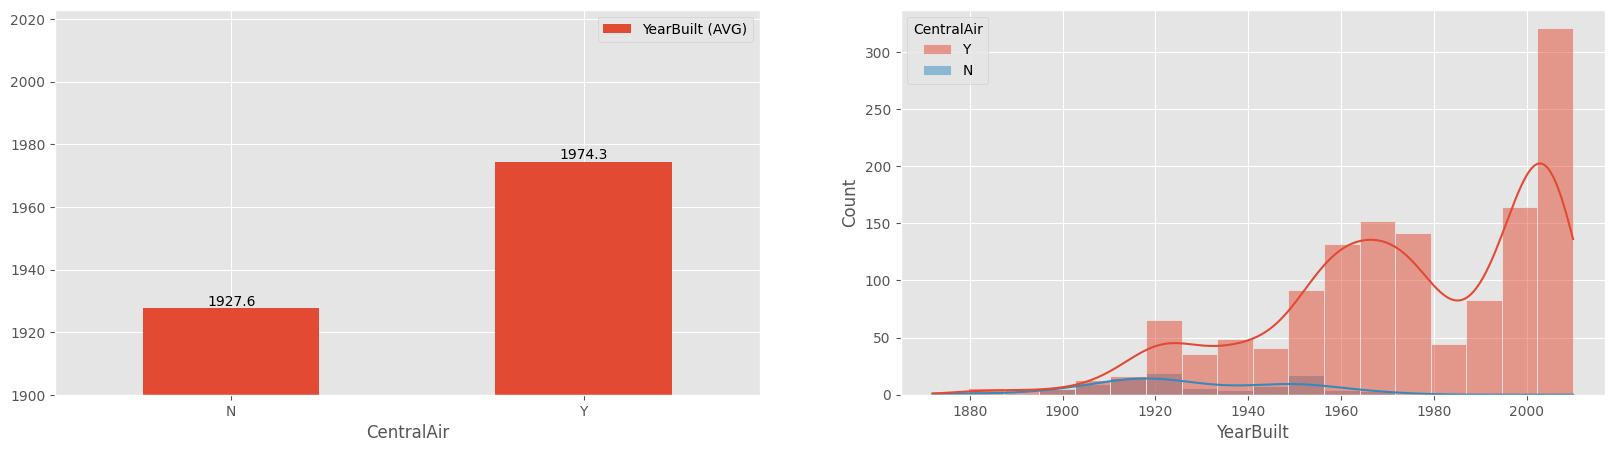

In [35]:
stattest_quanti(df,'YearBuilt', 'CentralAir' , low_limit=1900, upper_limit=2023)

##### Electrical

SalePrice,LOW,MEDIUM,HIGH
Electrical,,,
FuseA,81.914894,18.085106,0.00000
FuseF,96.296296,3.703704,0.00000
FuseP,100.000000,0.000000,0.00000
Mix,100.000000,0.000000,0.00000
NA,0.000000,100.000000,0.00000
SBrkr,38.380810,52.998501,8.62069


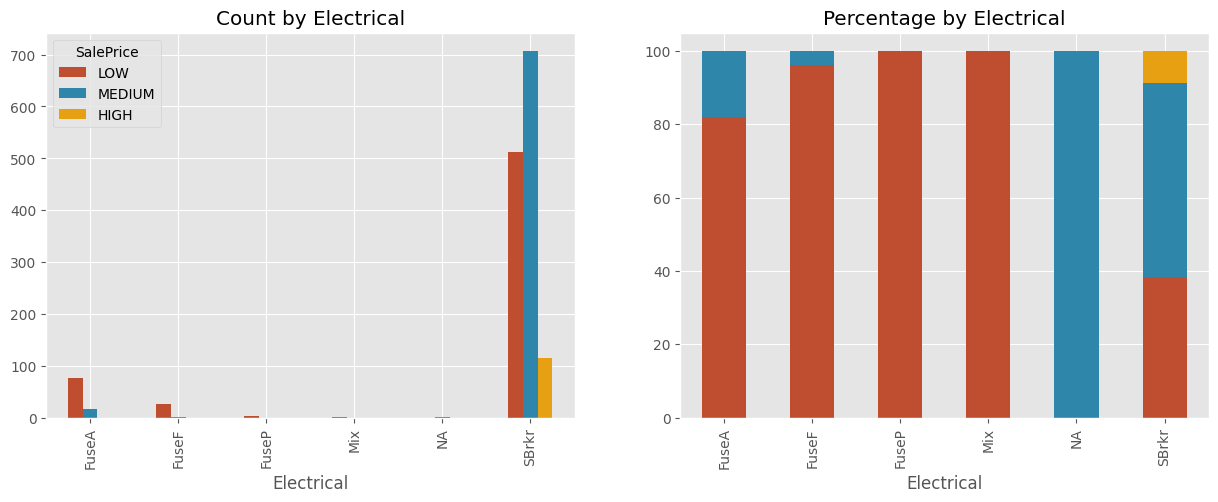

In [36]:
frequencies_and_percentages(df,'SalePrice','Electrical')

In [37]:
IG(df,'SalePrice','Electrical')

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.060141516515176664

In [38]:
len(df[df['Electrical'] == 'NA'])

1

##### 1stFlrSF

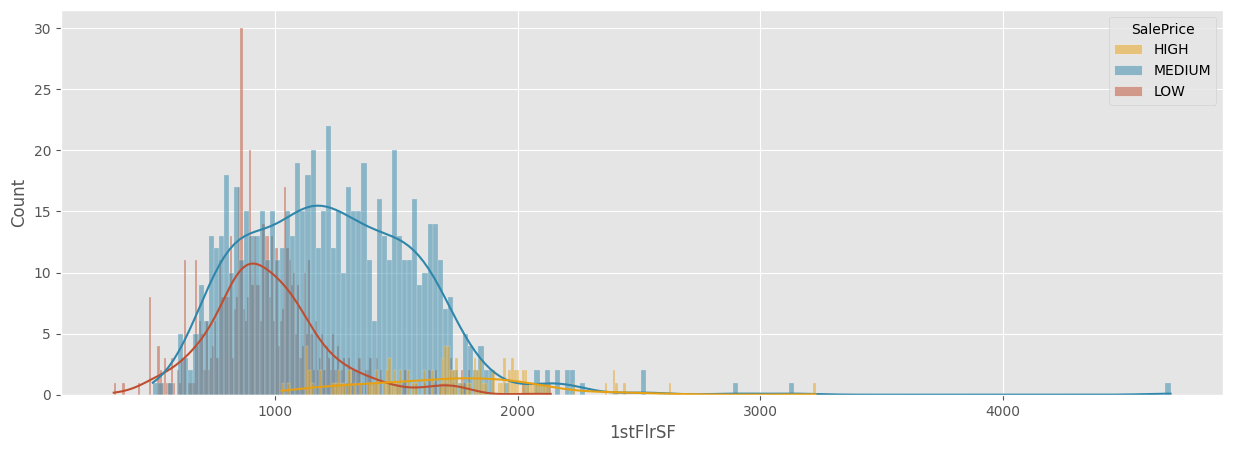

In [39]:
histplot(df,'SalePrice','1stFlrSF',bins=200)

ANOVA Test - Outcome
P-Value: 2.555821024618768e-104 [<0.05]


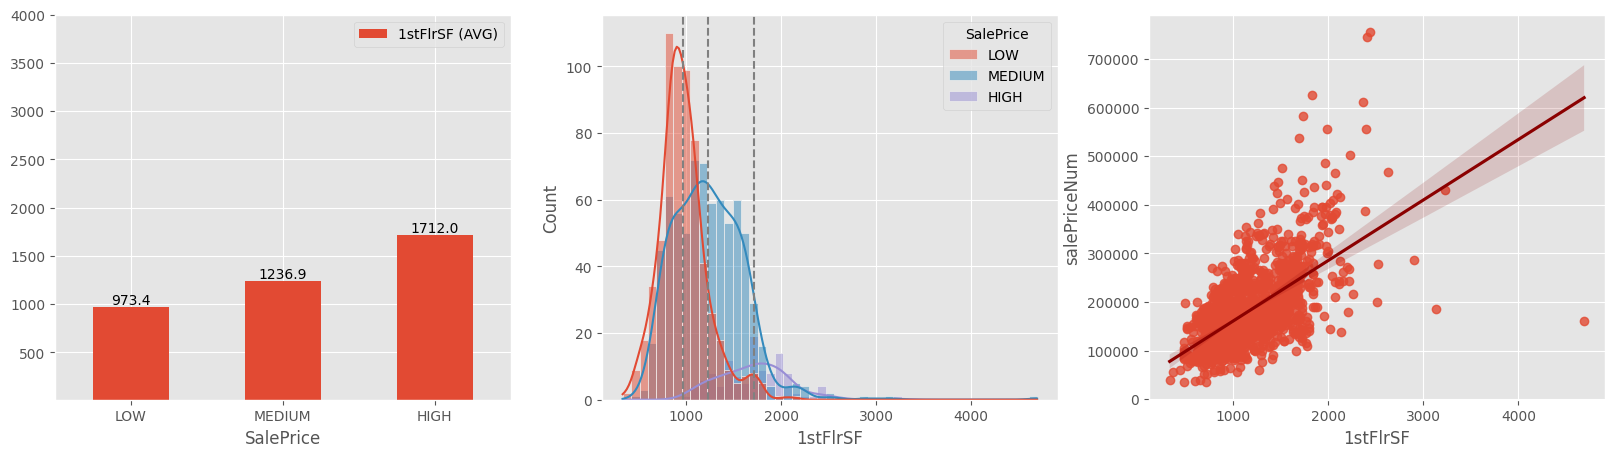

In [40]:
stattest_quanti(df,'1stFlrSF',low_limit=10, upper_limit=4000)

0.43125231655580953 3.447409108631451e-67


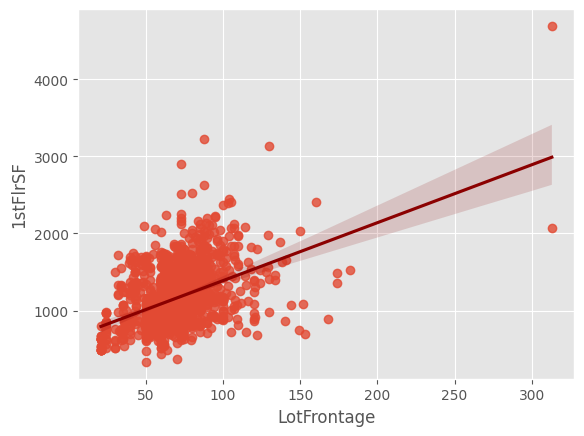

In [41]:
set_means(df,'1stFlrSF')
correlation(df, 'LotFrontage', '1stFlrSF')


##### 2ndFlrSF


Id
MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YrSold
SaleType
SaleCondition
SalePrice
salePriceNum


#### Results

| Attribute                     | Description                                                                                   |
|------------------------------	|----------------------------------------------	                                                |
| ID                        	| Maximum entropy and not correlated  with the target attribute, removed                        |
| Age               	        | Good correlation with values: DrugA and DrugB of the target attribute 	                    |
| Sex                    	    | Seems to not influence the target attribute, low IG, may be removed     	                    |
| BP                	        | Good predictor, it influences the target attribute                                            |
| Cholesterol           	    | Good predictor, it influences two attribute value of the target attribute: DrugX and DrugC    |
| Na                            | Good predictor                              	                                                |
| K 	                        | Good predictor 	                                                                            |
| Drug            	            | Class label                              	                                                |

### **Data Preparation**

#### Remove null values

In [42]:
df.dropna(inplace = True)
df.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
salePriceNum     0
Length: 82, dtype: int64

#### Remove attributes

In [43]:
df.drop(columns=['ID'], inplace = True)
df_ws = df.drop(columns=['Sex'])

KeyError: "['ID'] not found in axis"

#### Set type category

In [ ]:
df["Sex"] = df["Sex"].astype("category")
df["BP"] = df["BP"].astype("category")
df["Cholesterol"] = df["Cholesterol"].astype("category")
df["Drug"] = df["Drug"].astype("category")


df_ws["BP"] = df["BP"].astype("category")
df_ws["Cholesterol"] = df["Cholesterol"].astype("category")
df_ws["Drug"] = df["Drug"].astype("category")

#### Binarization

In [ ]:
# DF 
cat_attributes = list(df.select_dtypes(include = ['category']).columns)
cat_attributes.remove('Drug')
df_bin = pd.get_dummies(df, columns = cat_attributes)

## DF WS
cat_attributes = list(df_ws.select_dtypes(include = ['category']).columns)
cat_attributes.remove('Drug')
df_bin_ws = pd.get_dummies(df_ws, columns = cat_attributes)

df_bin.head()
df_bin_ws.head()

,Age,Na,K,Drug,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,0.792535,0.031258,drugY,1,0,0,1,0
1,47,0.739309,0.056468,drugC,0,1,0,1,0
2,47,0.697269,0.068944,drugC,0,1,0,1,0
3,28,0.563682,0.072289,drugX,0,0,1,1,0
4,61,0.559294,0.030998,drugY,0,1,0,1,0


### **Modeling**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

#### Creation of training, valuation and test sets

In [ ]:
seed = 101
test_size = .3
val_size = .2

# # DF 
# x = np.array(df.drop(columns="Drug").values)
# y = np.array(df['Drug'].values)

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

# DF BIN 
x_bin = np.array(df_bin.drop(columns="Drug").values)
y_bin = np.array(df_bin['Drug'].values)

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(x_bin, y_bin, test_size=test_size, random_state=seed)
x_train_bin, x_val_bin, y_train_bin, y_val_bin = train_test_split(x_train_bin, y_train_bin, test_size=val_size, random_state=seed)


# DF WITHOUT SEX
x_bin_ws = np.array(df_bin_ws.drop(columns="Drug").values)
y_bin_ws = np.array(df_bin_ws['Drug'].values)

# DF BIN
x_train_bin_ws, x_test_bin_ws, y_train_bin_ws, y_test_bin_ws = train_test_split(x_bin_ws, y_bin_ws, test_size=test_size, random_state=seed)
x_train_bin_ws, x_val_bin_ws, y_train_bin_ws, y_val_bin_ws = train_test_split(x_train_bin_ws, y_train_bin_ws, test_size=val_size, random_state=seed)


#### Creation of models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report

#### WITH SEX

In [ ]:
# models = []
# models.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
# models.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed)))
# models.append(('GaussianNaiveBayes', GaussianNB()))
# models.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=500, verbose=True, 
#                                               random_state=seed)))

models_bin = []
models_bin.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
models_bin.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed)))
models_bin.append(('GaussianNaiveBayes', GaussianNB()))
models_bin.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=500, verbose=True, 
                                              random_state=seed)))

for name, model_bin in models_bin:
    print(name)
    model_bin.fit(x_train_bin, y_train_bin)

    y_val_pred = model_bin.predict(x_val_bin)
    
    print('Classification metrics: ')
    print(classification_report(y_val_bin, y_val_pred, zero_division=1))

C45
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.50      1.00      0.67         2
       drugB       1.00      0.80      0.89         5
       drugC       0.33      1.00      0.50         1
       drugX       1.00      1.00      1.00         3
       drugY       1.00      0.81      0.90        16

    accuracy                           0.85        27
   macro avg       0.77      0.92      0.79        27
weighted avg       0.94      0.85      0.87        27

CART
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.67      1.00      0.80         2
       drugB       1.00      0.80      0.89         5
       drugC       0.25      1.00      0.40         1
       drugX       1.00      0.67      0.80         3
       drugY       1.00      0.88      0.93        16

    accuracy                           0.85        27
   macro avg       0.78      0.87      0.76        27
weighted avg      

#### WS

In [ ]:
models_bin_ws = []
models_bin_ws.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
models_bin_ws.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed)))
models_bin_ws.append(('GaussianNaiveBayes', GaussianNB()))
models_bin_ws.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=500, verbose=True, 
                                              random_state=seed)))

for name, model_bin_ws in models_bin_ws:
    print(name)
    model_bin_ws.fit(x_train_bin_ws, y_train_bin_ws)

    y_val_pred_ws = model_bin_ws.predict(x_val_bin_ws)
    
    print('Classification metrics: ')
    print(classification_report(y_val_bin_ws, y_val_pred_ws, zero_division=1))

C45
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.50      1.00      0.67         2
       drugB       1.00      0.80      0.89         5
       drugC       0.33      1.00      0.50         1
       drugX       1.00      1.00      1.00         3
       drugY       1.00      0.81      0.90        16

    accuracy                           0.85        27
   macro avg       0.77      0.92      0.79        27
weighted avg       0.94      0.85      0.87        27

CART
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.67      1.00      0.80         2
       drugB       1.00      0.80      0.89         5
       drugC       0.33      1.00      0.50         1
       drugX       1.00      0.67      0.80         3
       drugY       1.00      0.94      0.97        16

    accuracy                           0.89        27
   macro avg       0.80      0.88      0.79        27
weighted avg      

/home/instafiore/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### **Evaluation**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sb.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

#### Precision, Recall and Accuracy

*For the decison tree is better to use Gini Index and ds_ws*

In [ ]:
model = DecisionTreeClassifier(criterion='entropy', random_state=seed)
model.fit(x_train_bin_ws, y_train_bin_ws)
predictions = model.predict(x_test_bin_ws)

In [ ]:
print(f'Accuracy: {accuracy_score(y_test_bin_ws, predictions):.2f}')

Accuracy: 0.89


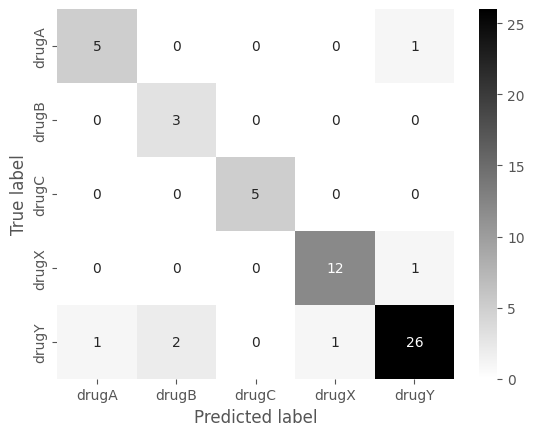

In [ ]:
a = df["Drug"].unique().tolist()
a.sort() 
make_confusion_matrix(confusion_matrix(y_test_bin_ws, predictions), categories= a , cmap='binary')

In [ ]:
print('Classification report')
print(classification_report(y_test_bin_ws, predictions))

Classification report
              precision    recall  f1-score   support

       drugA       0.83      0.83      0.83         6
       drugB       0.60      1.00      0.75         3
       drugC       1.00      1.00      1.00         5
       drugX       0.92      0.92      0.92        13
       drugY       0.93      0.87      0.90        30

    accuracy                           0.89        57
   macro avg       0.86      0.92      0.88        57
weighted avg       0.91      0.89      0.90        57



##### **Compute the Roc Curve for each class**

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
one_hot_encoding = np.array(pd.get_dummies(y_test_bin_ws, columns = ['Drug']))

probs = []
 
for _, model in models_bin_ws:
    model.fit(x_train_bin_ws, y_train_bin_ws)
    proba = model.predict_proba(x_train_bin_ws)
    probs.append(proba)



[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0.

/home/instafiore/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y_train_bin_ws))):
    plt.figure()
    m = 0

    for name, _ in models_bin_ws:
        fpr[i], tpr[i] , _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
        
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=5, label=name + f' (area = {roc_auc[i]:.2f})')
        m += 1

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(np.unique(y_train_bin_ws)[i]))
    plt.legend(loc='lower right')

    plt.show()  

ValueError: Found input variables with inconsistent numbers of samples: [57, 106]

<Figure size 640x480 with 0 Axes>